<a href="https://colab.research.google.com/github/taasinsaquib/ALL-Augmentations/blob/main/Class_Imbalance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers.experimental import preprocessing
#from cnnArchitectures.Xception import get_xception_model
from sklearn.model_selection import StratifiedKFold
import os
import datetime

import pickle

%matplotlib inline
%reload_ext tensorboard

In [9]:
# Set up dataset parameters
BATCH_SIZE = 16
IMAGE_SIZE = (256, 256)
SEED = 322
PREFETCH_BUFFER_SIZE = 400
SHUFFLE_BUFFER_SIZE = 1000
CACHE_DIR = "caches/ds_cache"
ds_params = dict(
    labels="inferred",
    label_mode="categorical",
    class_names=["all", "hem"],
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=SEED
)

# Connect to Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd drive/My\ Drive/CS\ M226

/content/drive/My Drive/CS M226


# Data Splits

In [ ]:
# Training
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    './C-NMC_Leukemia/training_data/fold_0',
    labels="inferred",
    class_names=["all", "hem"],
    label_mode="int",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE, 
)

Found 8531 files belonging to 2 classes.


In [ ]:
# Validation
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    './C-NMC_Leukemia/training_data/val',
    labels="inferred",
    class_names=["all", "hem"],
    label_mode="int",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE, 
)

Found 2130 files belonging to 2 classes.


In [10]:
# Test
test_df = pd.read_csv('./C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv')

In [11]:
test_labels = test_df.labels.values
print(test_labels)

[1 1 1 ... 0 1 1]


In [12]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    './C-NMC_Leukemia/validation_data/',
    labels=test_labels.tolist(),
    label_mode="int",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE, 
)

Found 1867 files belonging to 1 classes.


# Model

In [ ]:
def get_cnn_model_1(input_shape):

    kernel_initializer = 'lecun_uniform'
    bias_initializer = 'lecun_uniform'
    kernel_regularizer = None
    activation = "selu"

    model = tf.keras.Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape, 
                     data_format="channels_last", kernel_initializer=kernel_initializer, 
                     bias_initializer=bias_initializer, kernel_regularizer=kernel_regularizer
                    ))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), data_format="channels_last", kernel_initializer=kernel_initializer, 
                     bias_initializer=bias_initializer, kernel_regularizer=kernel_regularizer
                    ))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(3, 3)))

    model.add(Conv2D(128, (3, 3), data_format="channels_last", kernel_initializer=kernel_initializer, 
                     bias_initializer=bias_initializer, kernel_regularizer=kernel_regularizer
                    ))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(3, 3)))

    model.add(Conv2D(256, (3, 3), data_format="channels_last", kernel_initializer=kernel_initializer, 
                     bias_initializer=bias_initializer, kernel_regularizer=kernel_regularizer
                    ))
    model.add(Activation(activation))
    model.add(Dropout(0.6))

    # adding fully connected layers
    model.add(Flatten())
    model.add(Dense(512, kernel_initializer=kernel_initializer, bias_initializer=bias_initializer))
    model.add(Activation(activation))
    model.add(Dropout(0.8))
    model.add(Dense(256, kernel_initializer=kernel_initializer, bias_initializer=bias_initializer))
    model.add(Activation(activation))
    model.add(Dropout(0.8))
    model.add(Dense(128, kernel_initializer=kernel_initializer, bias_initializer=bias_initializer))
    model.add(Activation(activation))
    model.add(Dropout(0.7))
    model.add(Dense(64, kernel_initializer=kernel_initializer, bias_initializer=bias_initializer))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    return model

In [ ]:
model = get_cnn_model_1(IMAGE_SIZE + (3,))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
activation_1 (Activation)    (None, 125, 125, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 41, 41, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 39, 39, 128)       7

In [ ]:
model.load_weights("w.h5")

In [ ]:
adam_opt = tf.keras.optimizers.Adam(learning_rate=0.0001, amsgrad=True)
metrics = ["accuracy", tf.keras.metrics.Precision(name="precision")]

In [ ]:
# compile our new model
model.compile(
    optimizer=adam_opt,
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=metrics
)

In [ ]:
model_default = model
print(model_default.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
activation_1 (Activation)    (None, 125, 125, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 41, 41, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 39, 39, 128)       7

# Learning (transfer/retrain)

In [ ]:
model_checkpoint_callback1 = tf.keras.callbacks.ModelCheckpoint(
    filepath="./prec_checkpoints/",
    save_weights_only=True,
    monitor='val_precision',
    mode='max',
    save_best_only=True)

model_checkpoint_callback2 = tf.keras.callbacks.ModelCheckpoint(
    filepath="./",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
def retrain_imbalance(model, epochs, train_data, val_data, class_weights):
  for l in model.layers:
    l.set_trainable = True
  
  return model.fit(train_data, epochs=epochs, callbacks=[model_checkpoint_callback1], validation_data=val_data, class_weight=class_weights)

# Class Imbalances

In [ ]:
from sklearn.utils import class_weight

In [ ]:
# ALL 5822
# HEM 2709

ones = np.ones(5822)
zeros = np.zeros(2709)

fake_labels_count = np.array([])
fake_labels_count = np.append(fake_labels_count, ones, axis=0)
fake_labels_count = np.append(fake_labels_count, zeros, axis=0)
print(len(fake_labels_count))

8531


In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(fake_labels_count),
                                                 fake_labels_count)
weights = {
    0: class_weights[0],
    1: class_weights[1],
}
print(weights)

{0: 1.5745662606127722, 1: 0.7326520096186877}


# Augmented Data

## Flip & Rotate

In [ ]:
datagen_flip = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range = 0.2,
    rotation_range = 180
)

In [ ]:
train_data_flipped = datagen_flip.flow_from_directory(
    './C-NMC_Leukemia/training_data/fold_0',
    class_mode='binary',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 8531 images belonging to 2 classes.


In [ ]:
## Test Generators, see images
# first_item = train_data_flipped.__getitem__(0)
# print(first_item.count)

## Blur (Flip and Rotate)

In [ ]:
import cv2

In [ ]:
# randomly apply blur with 30% ish chance
def preprocessing_blur(img):
  number_list = np.random.choice(3, 1, p = [0.33, 0.37, 0.30])

  if number_list[0] == 0:
    newImg = cv2.GaussianBlur(img, (21, 21),0)
    return newImg

  return img

In [ ]:
datagen_blur = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range = 0.2,
    rotation_range = 180,
    preprocessing_function=preprocessing_blur
    # featurewise_center=True,
    # featurewise_std_normalization=True
)

In [ ]:
train_data_blur = datagen_blur.flow_from_directory (
    './C-NMC_Leukemia/training_data/fold_0',
    class_mode='binary',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb'
)

Found 8531 images belonging to 2 classes.


## Noise (Flip and Rotate)

In [ ]:
from skimage.util import random_noise

In [ ]:
# again, randomly apply augmentation
def preprocessing_noise(img):
  number_list = np.random.choice(3, 1, p = [0.33, 0.37, 0.30])

  if number_list[0] == 0:
    newImg = random_noise(img, mode='gaussian', mean=0, var=0.1, clip=False)
    return newImg

  return img

In [ ]:
datagen_noise = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range = 0.2,
    rotation_range = 180,
    preprocessing_function=preprocessing_noise
)

In [ ]:
train_data_noise = datagen_noise.flow_from_directory (
    './C-NMC_Leukemia/training_data/fold_0',
    class_mode='binary',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE, 
)

Found 8531 images belonging to 2 classes.


# Full Training to Figure Out Num Epochs

## 5 epochs
* good results!

In [ ]:
# 5 epochs with class balancing
model_retrain_5 = model
model_retrain_5 = retrain_imbalance(model_retrain_5, 5, train_data, val_data, weights)
# model_retrain_5.model.save_weights('./retrain_weight.hdf5')
model_retrain_5.model.save('./retrain_imbalance/5.hdf5')

Epoch 1/5
534/534 [==============================] - 3345s 6s/step - loss: 0.4879 - accuracy: 0.8013 - precision: 0.8301 - val_loss: 0.4298 - val_accuracy: 0.8117 - val_precision: 0.9964
Epoch 2/5
534/534 [==============================] - 178s 334ms/step - loss: 0.4105 - accuracy: 0.8284 - precision: 0.8947 - val_loss: 0.3035 - val_accuracy: 0.8765 - val_precision: 0.9427
Epoch 3/5
534/534 [==============================] - 178s 333ms/step - loss: 0.3666 - accuracy: 0.8481 - precision: 0.9183 - val_loss: 0.3274 - val_accuracy: 0.8592 - val_precision: 0.9750
Epoch 4/5
534/534 [==============================] - 178s 333ms/step - loss: 0.3595 - accuracy: 0.8530 - precision: 0.9252 - val_loss: 0.2976 - val_accuracy: 0.8789 - val_precision: 0.9607
Epoch 5/5
534/534 [==============================] - 178s 333ms/step - loss: 0.3088 - accuracy: 0.8726 - precision: 0.9417 - val_loss: 0.4329 - val_accuracy: 0.8474 - val_precision: 0.9944


In [ ]:
model_retrain_5.model.evaluate(test_data, batch_size=128)

117/117 [==============================] - 421s 4s/step - loss: 2.8559 - accuracy: 0.3605 - precision: 0.7358


[2.8559107780456543, 0.36047133803367615, 0.7358490824699402]

In [ ]:
# Save history
with open('./retrain_imbalance/5_history', 'wb') as file_pi:
  pickle.dump(model_retrain_5.history, file_pi) 

## 10 epochs
* accuracy went down
* same precision
* loss is higher

In [ ]:
# try 5 more epochs
model_retrain_weight_10 = retrain_imbalance(model_retrain_weight.model, 5, train_data, val_data, weights)
model_retrain_weight_10.model.save_weights('./retrain_weight_10.hdf5')

Epoch 1/5
534/534 [==============================] - 3137s 6s/step - loss: 0.2972 - accuracy: 0.8741 - precision: 0.9323 - val_loss: 0.3594 - val_accuracy: 0.8563 - val_precision: 0.9795
Epoch 2/5
534/534 [==============================] - 180s 337ms/step - loss: 0.2854 - accuracy: 0.8810 - precision: 0.9384 - val_loss: 0.2665 - val_accuracy: 0.8906 - val_precision: 0.9848
Epoch 3/5
534/534 [==============================] - 187s 350ms/step - loss: 0.2856 - accuracy: 0.8827 - precision: 0.9429 - val_loss: 0.4093 - val_accuracy: 0.8432 - val_precision: 1.0000
Epoch 4/5
534/534 [==============================] - 186s 347ms/step - loss: 0.2551 - accuracy: 0.8922 - precision: 0.9470 - val_loss: 0.2993 - val_accuracy: 0.8803 - val_precision: 0.9930
Epoch 5/5
534/534 [==============================] - 178s 333ms/step - loss: 0.2467 - accuracy: 0.9024 - precision: 0.9536 - val_loss: 0.3451 - val_accuracy: 0.8751 - val_precision: 0.9952


In [ ]:
model_retrain_weight_10.model.evaluate(test_data, batch_size=128)

117/117 [==============================] - 400s 3s/step - loss: 3.0019 - accuracy: 0.3664 - precision: 0.7250


[3.001899003982544, 0.36636313796043396, 0.7250000238418579]

# Augmentation Retrains

## Flip and Rotate

In [ ]:
model_retrain_flip = model
model_retrain_flip = retrain_imbalance(model_retrain_flip, 5, train_data_flipped, val_data, weights)
# model_retrain_flip.model.save_weights('./retrain_imbalance_flip.hdf5')
model_retrain_flip.model.save('./retrain_imbalance/flip')

Epoch 1/5
534/534 [==============================] - 872s 2s/step - loss: 0.5992 - accuracy: 0.6937 - precision: 0.6778 - val_loss: 0.3653 - val_accuracy: 0.8624 - val_precision: 0.9850
Epoch 2/5
534/534 [==============================] - 195s 366ms/step - loss: 0.5103 - accuracy: 0.7429 - precision: 0.8028 - val_loss: 0.4127 - val_accuracy: 0.8615 - val_precision: 0.9898
Epoch 3/5
534/534 [==============================] - 195s 366ms/step - loss: 0.4614 - accuracy: 0.7772 - precision: 0.8406 - val_loss: 0.4492 - val_accuracy: 0.8742 - val_precision: 0.9813
Epoch 4/5
534/534 [==============================] - 193s 361ms/step - loss: 0.4039 - accuracy: 0.8156 - precision: 0.8792 - val_loss: 0.4064 - val_accuracy: 0.8911 - val_precision: 0.9590
Epoch 5/5
534/534 [==============================] - 194s 363ms/step - loss: 0.3604 - accuracy: 0.8426 - precision: 0.9065 - val_loss: 0.4351 - val_accuracy: 0.8887 - val_precision: 0.9457
Instructions for updating:
This property should not be use

In [ ]:
model_retrain_flip.model.evaluate(test_data, batch_size=128)

117/117 [==============================] - 416s 4s/step - loss: 4.0951 - accuracy: 0.3771 - precision: 0.6333


[4.095116138458252, 0.37707552313804626, 0.6333333253860474]

In [ ]:
# Save history
with open('./retrain_imbalance/flip_history', 'wb') as file_pi:
  pickle.dump(model_retrain_flip.history, file_pi) 

## Noise (Flip and Rotate)

In [ ]:
model_retrain_noise = model
model_retrain_noise = retrain_imbalance(model_retrain_noise, 5, train_data_noise, val_data, weights)
# model_retrain_noise.model.save_weights('./retrain_imbalance/noise')
model_retrain_noise.model.save('./retrain_imbalance/noise')

Epoch 1/5
534/534 [==============================] - 907s 2s/step - loss: 0.3575 - accuracy: 0.8432 - precision: 0.9068 - val_loss: 0.4891 - val_accuracy: 0.8944 - val_precision: 0.8929
Epoch 2/5
534/534 [==============================] - 230s 430ms/step - loss: 0.3356 - accuracy: 0.8576 - precision: 0.9150 - val_loss: 0.5310 - val_accuracy: 0.8883 - val_precision: 0.9154
Epoch 3/5
534/534 [==============================] - 230s 431ms/step - loss: 0.3315 - accuracy: 0.8575 - precision: 0.9145 - val_loss: 0.5940 - val_accuracy: 0.8770 - val_precision: 0.9466
Epoch 4/5
534/534 [==============================] - 227s 426ms/step - loss: 0.3284 - accuracy: 0.8621 - precision: 0.9145 - val_loss: 0.5050 - val_accuracy: 0.8864 - val_precision: 0.9041
Epoch 5/5
534/534 [==============================] - 229s 428ms/step - loss: 0.3331 - accuracy: 0.8538 - precision: 0.9121 - val_loss: 0.5160 - val_accuracy: 0.8826 - val_precision: 0.9103
INFO:tensorflow:Assets written to: ./retrain_imbalance/noi

In [ ]:
model_retrain_noise.model.evaluate(test_data, batch_size=128)

117/117 [==============================] - 423s 4s/step - loss: 4.7992 - accuracy: 0.3931 - precision: 0.6483


[4.799219608306885, 0.39314407110214233, 0.6482758522033691]

In [ ]:
# Save history
with open('./retrain_imbalance/noise_history', 'wb') as file_pi:
  pickle.dump(model_retrain_noise.history, file_pi) 

## Blur (Flip and Rotate)

In [ ]:
model_retrain_blur = model
model_retrain_blur = retrain_imbalance(model_retrain_blur, 5, train_data_blur, val_data, weights)
model_retrain_blur.model.save('./retrain_imbalance/blur')

Epoch 1/5
534/534 [==============================] - 874s 2s/step - loss: 0.3709 - accuracy: 0.8353 - precision: 0.9127 - val_loss: 0.6245 - val_accuracy: 0.8653 - val_precision: 0.9538
Epoch 2/5
534/534 [==============================] - 204s 381ms/step - loss: 0.3680 - accuracy: 0.8347 - precision: 0.9047 - val_loss: 0.8277 - val_accuracy: 0.8582 - val_precision: 0.9610
Epoch 3/5
534/534 [==============================] - 205s 383ms/step - loss: 0.3675 - accuracy: 0.8361 - precision: 0.9034 - val_loss: 1.1717 - val_accuracy: 0.8277 - val_precision: 0.9845
Epoch 4/5
534/534 [==============================] - 203s 380ms/step - loss: 0.3606 - accuracy: 0.8412 - precision: 0.9128 - val_loss: 0.7508 - val_accuracy: 0.8770 - val_precision: 0.9265
Epoch 5/5
534/534 [==============================] - 205s 384ms/step - loss: 0.3584 - accuracy: 0.8406 - precision: 0.8998 - val_loss: 0.7731 - val_accuracy: 0.8826 - val_precision: 0.8996
INFO:tensorflow:Assets written to: ./retrain_imbalance/blu

In [ ]:
model_retrain_blur.model.evaluate(test_data, batch_size=128)

117/117 [==============================] - 439s 4s/step - loss: 7.6598 - accuracy: 0.3878 - precision: 0.6319


[7.659767150878906, 0.38778790831565857, 0.6319444179534912]

In [ ]:
with open('./retrain_imbalance/blur_history', 'wb') as file_pi:
  pickle.dump(model_retrain_blur.history, file_pi) 

TODO Marlin, create error bars for these

# Load Models

In [9]:
model_inception = tf.keras.models.load_model('./retrain_inception_resnet/inception')
model_resnet    = tf.keras.models.load_model('./retrain_inception_resnet/resnet')

model_retrain_5     = tf.keras.models.load_model('./retrain_imbalance/5.hdf5')
model_retrain_flip  = tf.keras.models.load_model('./retrain_imbalance/flip')
model_retrain_noise = tf.keras.models.load_model('./retrain_imbalance/noise')
model_retrain_blur  = tf.keras.models.load_model('./retrain_imbalance/blur')

# Load Histories

In [11]:
history_inception = pickle.load(open('./retrain_inception_resnet/inception_history', "rb"))
resnet_inception  = pickle.load(open('./retrain_inception_resnet/resnet_history', "rb"))

history_5 = pickle.load(open('./retrain_imbalance/5_history', "rb"))
history_flip = pickle.load(open('./retrain_imbalance/flip_history', "rb"))
history_noise = pickle.load(open('./retrain_imbalance/noise_history', "rb"))
history_blur = pickle.load(open('./retrain_imbalance/blur_history', "rb"))

In [ ]:
print(history_5.keys())

dict_keys(['loss', 'accuracy', 'precision', 'val_loss', 'val_accuracy', 'val_precision'])


# Predict from Models

In [12]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [ ]:
test_data_128 = tf.keras.preprocessing.image_dataset_from_directory(
    './C-NMC_Leukemia/validation_data/',
    labels=test_labels.tolist(),
    label_mode="int",
    image_size=(128, 128),
    batch_size=BATCH_SIZE, 
)

Found 1867 files belonging to 1 classes.


In [ ]:
pred_inception = model_inception.predict(test_data_128)
pred_resnet    = model_resnet.predict(test_data_128)

In [ ]:
pred_5 = model_retrain_5.predict(test_data)

In [ ]:
pred_retrain_flip = model_retrain_flip.predict(test_data)

In [10]:
pred_retrain_noise = model_retrain_noise.predict(test_data)

In [13]:
 pred_retrain_blur = model_retrain_blur.predict(test_data)

# ROC

In [ ]:
pred = []
count = 0
for g in pred_inception.ravel():
  if g < 0.5:
    count +=1
    pred.append(0)
  else:
    pred.append(1)
print(count)

1867


In [ ]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels, pred_5.ravel())

In [ ]:
auc_keras = auc(fpr_keras, tpr_keras)

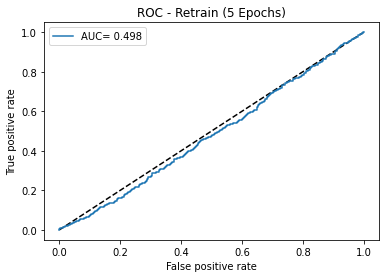

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='AUC= {:.3f}'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC - Retrain (5 Epochs)')
plt.legend(loc='best')
plt.show()

# Confusion Matrices

In [45]:
import seaborn as sn

In [41]:
n = 1867

In [42]:
test_labels_reshape = test_labels.reshape((test_labels.shape[0], 1))
test_labels_reshape_tensor = tf.constant(test_labels)
print(test_labels_reshape_tensor)

tf.Tensor([1 1 1 ... 0 1 1], shape=(1867,), dtype=int64)


In [17]:
confusion_mat_retrain_5 = tf.math.confusion_matrix(labels=test_labels_reshape_tensor,
                         predictions=pred_5,
                         num_classes=2)
confusion_mat_retrain_flip = tf.math.confusion_matrix(labels=test_labels_reshape_tensor,
                         predictions=pred_retrain_flip,
                         num_classes=2)
confusion_mat_retrain_noise = tf.math.confusion_matrix(labels=test_labels_reshape_tensor,
                         predictions=pred_retrain_noise,
                         num_classes=2)
confusion_mat_retrain_blur = tf.math.confusion_matrix(labels=test_labels_reshape_tensor,
                         predictions=pred_retrain_blur,
                         num_classes=2)

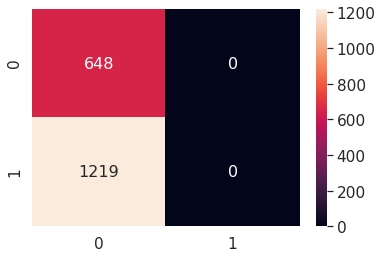

In [ ]:
df_cm_retrain_5 = pd.DataFrame(confusion_mat_retrain_5.numpy())

# for label size
sn.set(font_scale=1.4)
sn.heatmap(df_cm_retrain_5, annot=True, fmt='g', annot_kws={'size': 16}) # font size
plt.show()

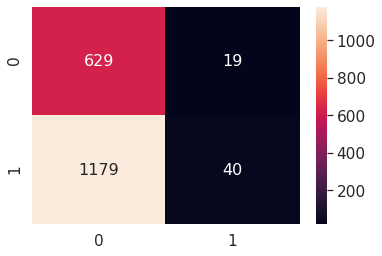

In [ ]:
df_cm_retrain_flip = pd.DataFrame(confusion_mat_retrain_flip.numpy())

# for label size
sn.set(font_scale=1.4)
sn.heatmap(df_cm_retrain_flip, annot=True, fmt='g', annot_kws={'size': 16}) # font size
plt.show()

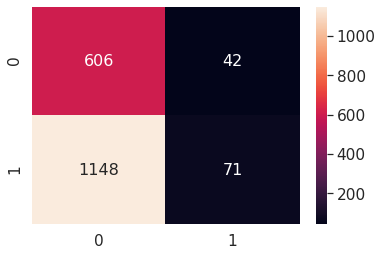

In [ ]:
df_cm_retrain_noise = pd.DataFrame(confusion_mat_retrain_noise.numpy())

# for label size
sn.set(font_scale=1.4)
sn.heatmap(df_cm_retrain_noise, annot=True, fmt='g', annot_kws={'size': 16}) # font size
plt.show()

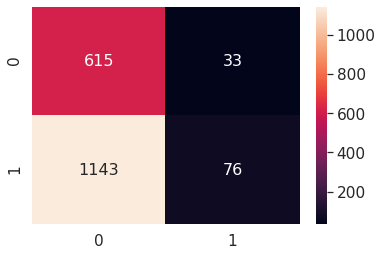

In [19]:
df_cm_retrain_blur = pd.DataFrame(confusion_mat_retrain_blur.numpy())

# for label size
sn.set(font_scale=1.4)
sn.heatmap(df_cm_retrain_blur, annot=True, fmt='g', annot_kws={'size': 16}) # font size
plt.show()

# Plots of Model Training Data

In [ ]:
print(model_retrain_blur.history.keys())

dict_keys(['loss', 'accuracy', 'precision', 'val_loss', 'val_accuracy', 'val_precision'])


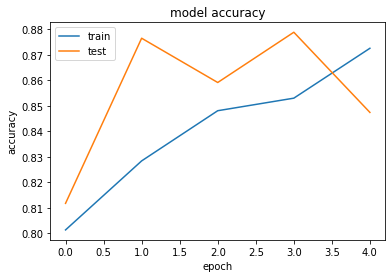

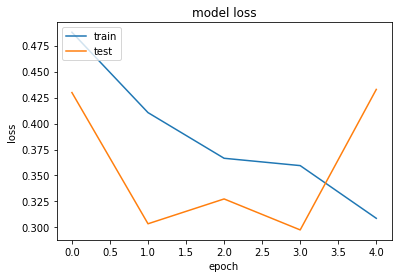

In [ ]:
# summarize history for accuracy
plt.plot(history_5['accuracy'])
plt.plot(history_5['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_5['loss'])
plt.plot(history_5['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

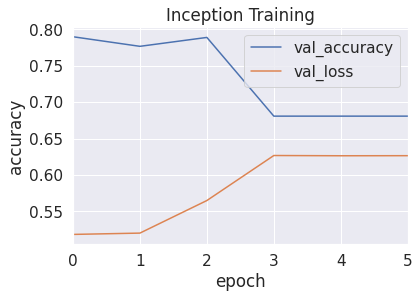

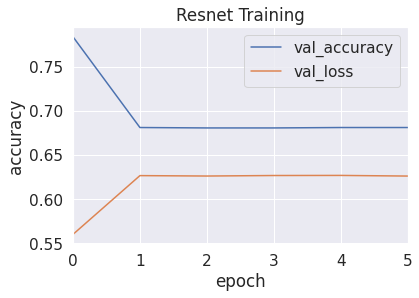

In [24]:
# summarize history for accuracy
# plt.subplot(2, 2, 1)
plt.plot(history_inception['val_accuracy'])
plt.plot(history_inception['val_loss'])
plt.title('Inception Training')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xlim((0,5))
plt.legend(['val_accuracy', 'val_loss'], loc='upper right')
plt.show()
# summarize history for loss
# plt.subplot(2, 2, 2)
plt.plot(resnet_inception['val_accuracy'])
plt.plot(resnet_inception['val_loss'])
plt.title('Resnet Training')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xlim((0,5))
plt.legend(['val_accuracy', 'val_loss'], loc='upper right')
plt.show()

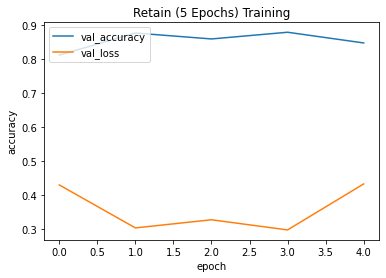

In [ ]:
plt.plot(history_5['val_accuracy'])
plt.plot(history_5['val_loss'])
plt.title('Retain (5 Epochs) Training')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val_accuracy', 'val_loss'], loc='upper left')
plt.show()

# Threshold

In [13]:
with open('retrain_noise_predict', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(pred_retrain_noise, filehandle)

In [6]:
with open('retrain_noise_predict', 'rb') as filehandle:
    # read the data as binary data stream
    pred_retrain_noise = pickle.load(filehandle)


In [17]:
df = pd.DataFrame({'guesses': pred_retrain_noise.ravel(), 'labels': test_labels})

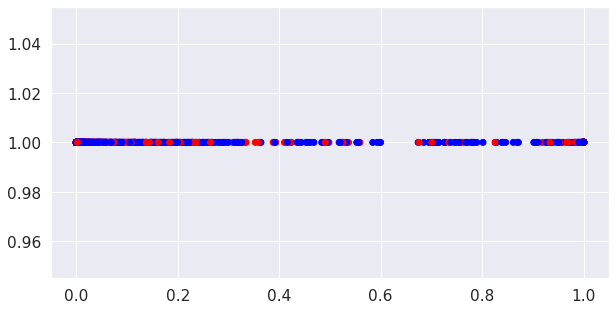

In [75]:
col = ['red', 'blue']
fig = plt.figure(figsize=(10,5))
plt.scatter(df['guesses'], np.ones(1867), c=[col[x] for x in df['labels']])

In [83]:
def analyzeThreshold(thresholds):

  data = {
      "TP": [],
      "FP": [],
      "FN": [],
      "TN": [],
      "acc": []
  }

  for th in thresholds:
    th_pred = []

    for x in pred_retrain_noise.ravel():
      if x < th:
        th_pred.append(0)
      else:
        th_pred.append(1)

    noise_03 = tf.math.confusion_matrix(labels=test_labels_reshape_tensor,
                            predictions=th_pred,
                            num_classes=2)

    df_noise_03 = pd.DataFrame(noise_03.numpy())
    # print('Threshold - {}'.format(th))
    # print(df_noise_03)
    # print('\n')

    data["TP"].append(df_noise_03[0][0]/1867)
    data["FP"].append(df_noise_03[0][1]/1867)
    data["FN"].append(df_noise_03[1][0]/1867)
    data["TN"].append(df_noise_03[1][1]/1867)

    correct = df_noise_03[0][0] + df_noise_03[1][1]
    data["acc"].append(correct/1867)

  return data
    # for label size
    # sn.set(font_scale=1.4)
    # sn.heatmap(df_noise_03, annot=True, fmt='g', annot_kws={'size': 16}) # font size
    # plt.show()

In [84]:
ths = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
d = analyzeThreshold(ths)

In [85]:
print(d)

{'TP': [0.0, 0.2544188537761114, 0.2779860739153723, 0.28548473486877346, 0.2897696839850027, 0.2929833958221746, 0.29619710765934654, 0.2967327262988752, 0.30048205677557577, 0.30101767541510444, 0.32619175147295126], 'FP': [0.0, 0.468130690948045, 0.5115158007498661, 0.5372254954472415, 0.5452597750401714, 0.5516871987145152, 0.5565077664702731, 0.5586502410283878, 0.5688269951794322, 0.5736475629351901, 0.6132833422603107], 'FN': [0.3470808784145688, 0.09266202463845742, 0.06909480449919657, 0.061596143545795394, 0.05731119442956615, 0.05409748259239421, 0.05088377075522228, 0.05034815211569363, 0.04659882163899304, 0.046063202999464384, 0.02088912694161757], 'TN': [0.6529191215854312, 0.18478843063738618, 0.1414033208355651, 0.1156936261381896, 0.10765934654525977, 0.10123192287091591, 0.09641135511515801, 0.09426888055704338, 0.08409212640599893, 0.07927155865024103, 0.03963577932512052], 'acc': [0.6529191215854312, 0.4392072844134976, 0.41938939475093734, 0.401178361006963, 0.397

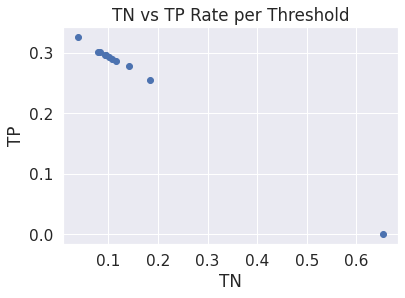

In [97]:
plt.title("TN vs TP Rate per Threshold")
plt.xlabel("TN")
plt.ylabel("TP")
plt.scatter(d["TN"], d["TP"])

# fig, ax = plt.subplots()
# ax.scatter(d["TN"], d["TP"])

# for i, th in enumerate(ths):
#     ax.annotate(th, (d["TN"][i], d["TP"][i]))

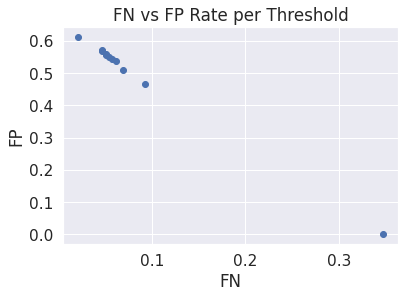

In [90]:
plt.title("FN vs FP Rate per Threshold")
plt.xlabel("FN")
plt.ylabel("FP")
plt.scatter(d["FN"], d["FP"])

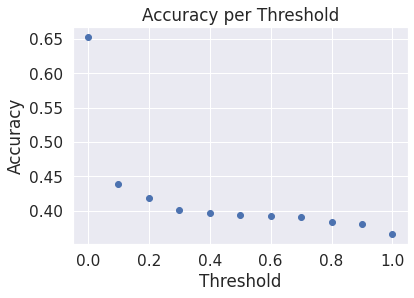

In [92]:
plt.title("Accuracy per Threshold")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.scatter(ths, d["acc"])